# Convolution with the Hartley transform 

The [Hartley transform](https://en.wikipedia.org/wiki/Hartley_transform) can be computed by summing the real and imaginary parts of the Fourier transform. 

\begin{equation}\begin{aligned}
\mathcal F \mathbf a &= \mathbf x + i\mathbf y
\\
\mathcal H \mathbf a &= \mathbf x + \mathbf y,
\end{aligned}\end{equation}

where $\mathbf a$, $\mathbf x$, and $\mathbf y$ are real-valued vectors, $\mathcal F$ is the Fourier transform, and  $\mathcal H$ is the Hartley transform. It has several useful properties.

- It is unitary, and also an involution: it is its own inverse.
- Its output is real-valued, so it can be used with numerical routines that cannot handle complex numbers.
- It can be computed in $\mathcal O (n \log(n))$ time using standard Fast Fourier Transform (FFT) libraries. 

These advantages make the Hartley transform useful for designing fast linear algebra routines that interoperate with libraries that [do not support complex numbers](https://stackoverflow.com/questions/43784197/minres-implementation-in-python). Disadvantages are that the Hartley spectrum is less intuitive than the Fourier spectrum, and that convolutions are tricker to compute. With the Fourier transform, convolutions can be computed using the convolution theorem: 

\begin{equation}\begin{aligned}
\mathbf a * \mathbf b = \mathcal F^{-1} [
(\mathcal F \mathbf a)
\circ
(\mathcal F \mathbf b)
]
\end{aligned}\end{equation}

where $\mathbf a$ and $\mathbf b$ are vectors, $\mathcal F$ is the Fourier transform, and $\circ$ denotes element-wise multiplication. 

Convolutions for real-valued inputs can also be computed using the Hartley transform, albeit with a bit more work. For the Fourier transform real-valied inputs, the negative frequencies are the complex conjugate of positive frequencies. That is, if the Fourier coefficient for $+\omega$ is $x + iy$, then the coefficient for $-\omega$ is $x-iy$. 

For real-valued inputs, this means that positive frequencies of the Hartley transform take on values $x + y$ and negative values $x - y$. These two components are orthogonal, and can be used to recover the original real and imaginary parts of the Fourer transform. 

\begin{equation}\begin{aligned}
\,[ \Re ({\mathcal F} \mathbf a)](\omega) &= \tfrac 1 2 \left\{
[\mathcal H \mathbf a](\omega)
+
[\mathcal H \mathbf a](-\omega)
\right\}
\\
\,[ \Im ({\mathcal F} \mathbf a)](\omega) &= \tfrac 1 2 \left\{
[\mathcal H \mathbf a](\omega)
-
[\mathcal H \mathbf a](-\omega)
\right\}
\end{aligned}\end{equation}


To convolve real-valued signals using the Hartley transform, convert the Hartley spectrum to the Fourier spectrum, and use the standard convolution theorem. This simplifies to:

\begin{equation}\begin{aligned}
\mathbf a*\mathbf b = \tfrac 1 2 \mathcal H^{-1}\{
&[\mathcal H \mathbf a](\omega)[\mathcal H \mathbf b](\hphantom{-}\omega) 
+
[\mathcal H \mathbf a](-\omega) [\mathcal H \mathbf b](\hphantom{-}\omega) 
\\ + 
&[\mathcal H \mathbf a](\omega) [\mathcal H \mathbf b](-\omega) 
-
[\mathcal H \mathbf a](-\omega) [\mathcal H \mathbf b](-\omega) 
\}
\end{aligned}\end{equation}

Here's an example in numpy/scipy:

```python
from pylab import *
    
# reference convolution
p  = exp(-0.5*linspace(-9,9,100)**2)
q  = randn(100)

fp = fft(p,norm='ortho')
fq = fft(q,norm='ortho')
z  = real(ifft(fp*fq,norm='ortho'))

# ~~ fht convolution
def fht(*args):
    f = fft(*args,norm='ortho')
    return real(f) + imag(f)

reverse = lambda a:roll(a[::-1],len(a)+1)

hp = fht(p)
hq = fht(q)
a  = hp*hq
b  = reverse(hp)*hq
hz = fht( b+a + reverse(b-a) )/2
print(max(abs(hz - z)))
```

```
>>>> 1.6653345369377348e-16
```

In [27]:
from pylab import *
    
# reference convolution
p  = exp(-0.5*linspace(-9,9,10)**2)
q  = randn(10)

fp = fft(p,norm='ortho')
fq = fft(q,norm='ortho')
z  = real(ifft(fp*fq,norm='ortho'))

# FHT convolution
def fht(*args,**kwargs):
    kwargs['norm']='ortho'
    f = fft(*args,**kwargs)
    return real(f) + imag(f)

reverse = lambda a:roll(a[::-1],1)

hp = fht(p)
hq = fht(q)
a  = hp*hq
b  = reverse(hp)*hq
hz = fht( b+a + reverse(b-a) )/2
print(max(abs(hz - z)))

5.551115123125783e-17


In [2]:
A = (diag(hp + reverse(hp)) + fliplr(diag(hp - reverse(hp))))/2

In [3]:
hz = fht(A@hq)

In [4]:
Kf = fft2(K0,norm='ortho')

x = randn(L,L)
y = conv(Kf,x).reshape(L,L)
y_ = y
subplot(131); imshow(y)

reverse1 = lambda a:roll(a[:,::-1],1,axis=1)
reverse2 = lambda a:roll(a[::-1,:],1,axis=0)
reverse  = lambda a: reverse2(reverse1(a))

permutation = int32(down@reverse((up@(arange(R))).reshape(L,L)).ravel())
xf = fft2(x,norm='ortho')
kf = fft2(K0,norm='ortho')
xh = real(xf) + imag(xf)
kh = real(kf) + imag(kf)
xh = down@xh.ravel()
kh = down@kh.ravel()
kr = kh[permutation]
xr = xh[permutation]
a  = kh+kr
b  = kh-kr
yh = (up@(xh*a+xr*b)).reshape(L,L)
yh /= 2
y  = fft2(yh,norm='ortho')
y  = real(y) + imag(y)

subplot(132); imshow(y.reshape(L,L))
print(max(abs(y-y_)))

def hconv(kh,xh):
    kr = kh[permutation]
    xr = xh[permutation]
    a  = kh+kr
    b  = kh-kr
    return (xh*a+xr*b)/2

def hconm(kh,Q):
    return array([hconv(kh,q) for q in Q.T]).T

xf = fft2(x,norm='ortho')
kf = fft2(K0,norm='ortho')
xh = real(xf) + imag(xf)
kh = real(kf) + imag(kf)
xh = down@xh.ravel()
kh = down@kh.ravel()
yh = (up@hconv(kh,xh)).reshape(L,L)
y  = fft2(yh,norm='ortho')
y  = real(y) + imag(y)

subplot(133); imshow(y.reshape(L,L))
print(max(abs(y-y_)))

0.2194263859319154


In [5]:
print(max(abs(hp*rq - flipud(diag(hp))@hq )))

NameError: name 'rq' is not defined

In [ ]:
d,e,f,g = hp*hq,rp*hq,hp*rq,rp*rq

In [ ]:

hp = fht(p)
hq = fht(q)
hz = (0
         + reverse(hp)*hq
         + hp*hq 
         + hp*reverse(hq)
         -reverse(hp)*reverse(hq)
        )/2

a = diag(hp + reverse(hp))
a[reverse(arange(10)),arange(10)] += reverse(hp) - hp
print(max(abs( hz - a @ hq / 2 )))
imshow(a)

In [ ]:
argsort(reverse(arange(10)))

In [ ]:
hq[i]-reverse(hq)

In [ ]:
reverse(g) - d

In [ ]:
hp*hq

In [ ]:
a,b = hp*hq, reverse(hp)*hq
hz  = fht( b+a + reverse(b-a) )/2
print(max(abs(hz - z)))

In [29]:
roll(x,1,axis=1)

array([[ 0.46308385, -0.98155066,  0.04848734,  2.11694996, -0.36511416,
        -0.20794063, -0.98877899,  0.38478441, -0.35722563,  1.33651122],
       [ 1.29862949, -0.97201858,  1.25318734, -1.26599196, -0.28777522,
         0.05113758, -0.23253573, -0.12628125, -0.85526156, -0.72681102],
       [-0.61701609, -0.48260647, -0.20424728, -0.52998579,  1.02646461,
        -0.32233951, -0.8522937 ,  0.29826593, -0.8942738 ,  0.64021504],
       [ 1.6888989 ,  0.4873797 , -0.5296515 , -2.2687401 , -0.1582377 ,
         0.52118497,  0.28281254,  1.97132939, -0.70814305, -0.54182482],
       [ 0.81753514,  1.33020314, -0.45309912,  1.31881913, -0.03713225,
        -0.07009938,  1.43232386, -0.82585541,  0.42776382, -0.39245462],
       [-0.34659786,  0.39866954,  0.57434032, -0.13591593,  0.16105016,
        -0.90685662,  1.90599202,  0.00650503, -0.54062229,  0.25936559],
       [ 1.72785303,  0.2493582 ,  1.63137835, -0.59998825,  1.05847729,
         0.04189442, -0.86200235, -0.44510359

In [14]:
x = randn(10,10)

y = fft2(x,norm='ortho')
y = real(y) + imag(y)

np.max(abs(  fht(fht(x,axis=0),axis=1) - y  ))

1.8887556211511507

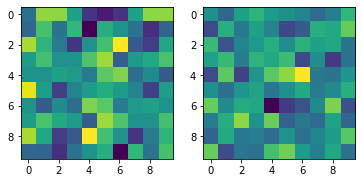

In [26]:
x = randn(10,10)
y = fft2(x)

subplot(121)
imshow(real(y))
subplot(122)
imshow(imag(y))